In [65]:
model_dir = 'models/keras/patience10_vgg16_multiclass_128/'
#model_dir = 'models/keras/patience10_vgg16/'

In [66]:
from keras.models import load_model, model_from_json
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [67]:
import h5py
f = h5py.File(model_dir + 'best_model.h5','r+')
data_p = f.attrs['training_config']
data_p = data_p.decode().replace("learning_rate","lr").encode()
f.attrs['training_config'] = data_p
f.close()

In [145]:
from keras import metrics
import functools
top3_acc = functools.partial(metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

dependencies = {
    'top3_acc': top3_acc
}

import innvestigate
import innvestigate.utils as iutils
import PIL
model = load_model(model_dir + 'best_model.h5', custom_objects=dependencies)
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)
#analyzer = innvestigate.create_analyzer("lrp.z", model_wo_softmax, neuron_selection_mode="index")
analyzer = innvestigate.create_analyzer("gradient", model_wo_softmax,
                                                       neuron_selection_mode="index")

Actinic keratosis 0.10474168
Basal cell carcinoma 0.11454615
Benign keratosis 0.086903825
Dermatofibroma 0.05511831
Melanoma 0.09682062
Melanocytic nevus 0.37448615
Squamous cell carcinoma 0.035451457
Vascular lesion 0.13193183


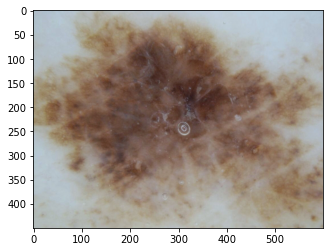

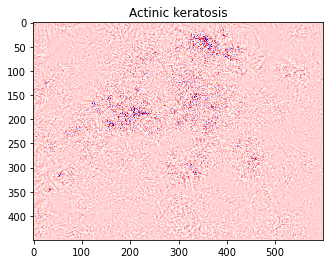

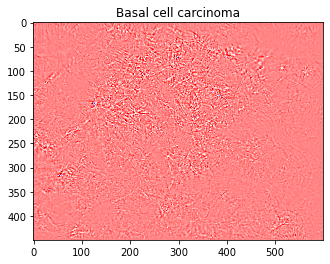

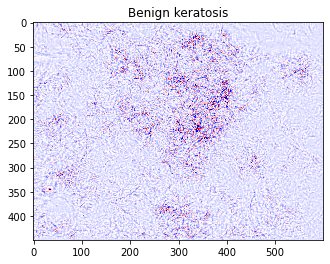

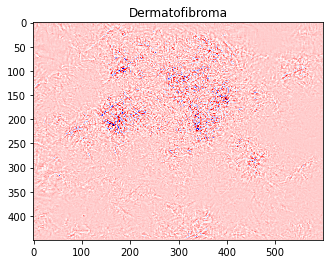

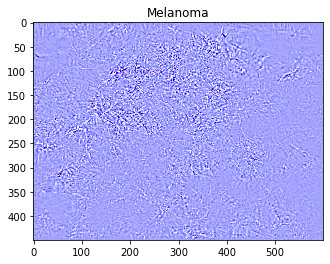

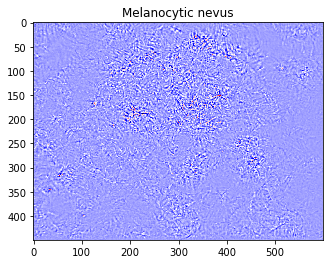

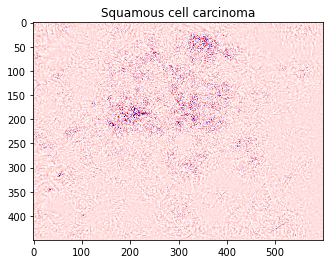

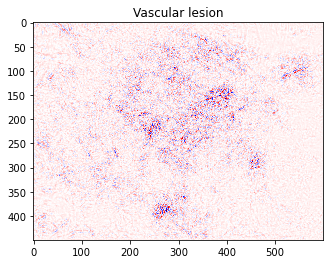

In [146]:
paths = ['data/cropped_multiclass/train/MEL/ISIC_0011350.jpg']
mapping = ['AK' , 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
classes = {'AK': 'Actinic keratosis', 'BCC' : 'Basal cell carcinoma', 'BKL' : 'Benign keratosis', 'DF' : 'Dermatofibroma', 'MEL' : 'Melanoma', 'NV' : 'Melanocytic nevus', 'SCC' : 'Squamous cell carcinoma', 'VASC' : 'Vascular lesion'}

for path in paths:
    image = np.array(Image.open(path))
    expanded = np.expand_dims(image, axis=0)
    probs = model.predict(expanded)
    for i in range(8):
        print(classes[mapping[i]], probs[0][i])

    plt.imshow(image)
    plt.show()
    for i in range(8):
        a = analyzer.analyze(expanded, i)
        a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
        a /= np.max(np.abs(a))
        plt.imshow(a.squeeze(), cmap='seismic', interpolation='nearest')
        plt.title(classes[mapping[i]])
        plt.show()
        

In [83]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


In [131]:
import keras
# Prepare image
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions
img_array = preprocess_input(get_img_array(paths[0], size=(600, 450)))

# Make model
model = load_model(model_dir + 'best_model.h5', custom_objects=dependencies)

# Print what the top predicted class is
preds = model.predict(img_array)

last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_2",
]


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


TypeError: unhashable type: 'Dimension'